# **1 | Update Libraries**

In [ ]:
!pip install --upgrade tensorflow
!pip install --upgrade tensorflow[and-cuda]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 19.6 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Fo

#**2 | Important Libraries**

In [ ]:
# General Imports
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

from sklearn.metrics import confusion_matrix

# Neural Network imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Multiply
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.utils as keras_utils
import matplotlib.pyplot as plt

# Image augmentation importrs
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.layers import RandomContrast
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.layers import RandomTranslation



# Training Model callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

# Print Tensorflow version
print(f'Tensorflow Version: {tf.__version__}')

SEED = 111

# Data Visualization updates
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (16, 10)
plt.rcParams.update({'font.size': 14})

Tensorflow Version: 2.15.0


#**3 | Data Processing**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##**Fold 1**

In [ ]:
def get_data_labels(directory, shuffle=True, random_state=0):
    from sklearn.utils import shuffle
    data_path = []
    data_index = []
    label_dict = {label: index for index, label in enumerate(sorted(os.listdir(directory)))}

    for label, index in label_dict.items():
        label_dir = os.path.join(directory, label)
        for image in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image)
            data_path.append(image_path)
            data_index.append(index)

    if shuffle:
        data_path, data_index = shuffle(data_path, data_index, random_state=random_state)

    return data_path, data_index

def parse_function(filename, label, image_size, n_channels):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, n_channels)
    image = tf.image.resize(image, image_size)
    return image, label

def get_dataset(paths, labels, image_size, n_channels=1, num_classes=4, batch_size=32):
    path_ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    image_label_ds = path_ds.map(lambda path, label: parse_function(path, label, image_size, n_channels),
                                 num_parallel_calls=tf.data.AUTOTUNE)
    return image_label_ds.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# Getting data labels
USER_PATH = "/content/drive/MyDrive/K-Fold Purpose/K Fold/1 Fold"
train_paths, train_index = get_data_labels(USER_PATH + '/Training', random_state=SEED)
test_paths, test_index = get_data_labels(USER_PATH + '/Testing', random_state=SEED)

# Printing traing and testing sample sizes
print('Training')
print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_index)}')
print('\nTesting')
print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_index)}')

# Prepare datasets with 4 classes and grayscale
batch_size = 32
image_dim = (168, 168)
train_ds = get_dataset(train_paths, train_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)
test_ds = get_dataset(test_paths, test_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)

# Output to show datasets
print(f"\nTraining dataset: {train_ds}")
print(f"\nTesting dataset: {test_ds}")

# Class mappings
class_mappings = {'Glioma': 0, 'Meninigioma': 1, 'Notumor': 2, 'Pituitary': 3}
inv_class_mappings = {v: k for k, v in class_mappings.items()}
class_names = list(class_mappings.keys())

Training
Number of Paths: 5613
Number of Labels: 5613

Testing
Number of Paths: 1410
Number of Labels: 1410

Training dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 168, 168, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

Testing dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 168, 168, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


##**Fold 2**

In [ ]:
def get_data_labels(directory, shuffle=True, random_state=0):
    from sklearn.utils import shuffle
    data_path = []
    data_index = []
    label_dict = {label: index for index, label in enumerate(sorted(os.listdir(directory)))}

    for label, index in label_dict.items():
        label_dir = os.path.join(directory, label)
        for image in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image)
            data_path.append(image_path)
            data_index.append(index)

    if shuffle:
        data_path, data_index = shuffle(data_path, data_index, random_state=random_state)

    return data_path, data_index

def parse_function(filename, label, image_size, n_channels):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, n_channels)
    image = tf.image.resize(image, image_size)
    return image, label

def get_dataset(paths, labels, image_size, n_channels=1, num_classes=4, batch_size=32):
    path_ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    image_label_ds = path_ds.map(lambda path, label: parse_function(path, label, image_size, n_channels),
                                 num_parallel_calls=tf.data.AUTOTUNE)
    return image_label_ds.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# Getting data labels
USER_PATH = "/content/drive/MyDrive/Dataset/Extracted"
train_paths, train_index = get_data_labels(USER_PATH + '/Training', random_state=SEED)
test_paths, test_index = get_data_labels(USER_PATH + '/Testing', random_state=SEED)

# Printing traing and testing sample sizes
print('Training')
print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_index)}')
print('\nTesting')
print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_index)}')

# Prepare datasets with 4 classes and grayscale
batch_size = 32
image_dim = (168, 168)
train_ds = get_dataset(train_paths, train_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)
test_ds = get_dataset(test_paths, test_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)

# Output to show datasets
print(f"\nTraining dataset: {train_ds}")
print(f"\nTesting dataset: {test_ds}")

# Class mappings
class_mappings = {'Glioma': 0, 'Meninigioma': 1, 'Notumor': 2, 'Pituitary': 3}
inv_class_mappings = {v: k for k, v in class_mappings.items()}
class_names = list(class_mappings.keys())

##**Fold 3**

In [ ]:
def get_data_labels(directory, shuffle=True, random_state=0):
    from sklearn.utils import shuffle
    data_path = []
    data_index = []
    label_dict = {label: index for index, label in enumerate(sorted(os.listdir(directory)))}

    for label, index in label_dict.items():
        label_dir = os.path.join(directory, label)
        for image in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image)
            data_path.append(image_path)
            data_index.append(index)

    if shuffle:
        data_path, data_index = shuffle(data_path, data_index, random_state=random_state)

    return data_path, data_index

def parse_function(filename, label, image_size, n_channels):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, n_channels)
    image = tf.image.resize(image, image_size)
    return image, label

def get_dataset(paths, labels, image_size, n_channels=1, num_classes=4, batch_size=32):
    path_ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    image_label_ds = path_ds.map(lambda path, label: parse_function(path, label, image_size, n_channels),
                                 num_parallel_calls=tf.data.AUTOTUNE)
    return image_label_ds.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# Getting data labels
USER_PATH = "/content/drive/MyDrive/Dataset/Extracted"
train_paths, train_index = get_data_labels(USER_PATH + '/Training', random_state=SEED)
test_paths, test_index = get_data_labels(USER_PATH + '/Testing', random_state=SEED)

# Printing traing and testing sample sizes
print('Training')
print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_index)}')
print('\nTesting')
print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_index)}')

# Prepare datasets with 4 classes and grayscale
batch_size = 32
image_dim = (168, 168)
train_ds = get_dataset(train_paths, train_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)
test_ds = get_dataset(test_paths, test_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)

# Output to show datasets
print(f"\nTraining dataset: {train_ds}")
print(f"\nTesting dataset: {test_ds}")

# Class mappings
class_mappings = {'Glioma': 0, 'Meninigioma': 1, 'Notumor': 2, 'Pituitary': 3}
inv_class_mappings = {v: k for k, v in class_mappings.items()}
class_names = list(class_mappings.keys())

##**Fold 4**

In [ ]:
def get_data_labels(directory, shuffle=True, random_state=0):
    from sklearn.utils import shuffle
    data_path = []
    data_index = []
    label_dict = {label: index for index, label in enumerate(sorted(os.listdir(directory)))}

    for label, index in label_dict.items():
        label_dir = os.path.join(directory, label)
        for image in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image)
            data_path.append(image_path)
            data_index.append(index)

    if shuffle:
        data_path, data_index = shuffle(data_path, data_index, random_state=random_state)

    return data_path, data_index

def parse_function(filename, label, image_size, n_channels):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, n_channels)
    image = tf.image.resize(image, image_size)
    return image, label

def get_dataset(paths, labels, image_size, n_channels=1, num_classes=4, batch_size=32):
    path_ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    image_label_ds = path_ds.map(lambda path, label: parse_function(path, label, image_size, n_channels),
                                 num_parallel_calls=tf.data.AUTOTUNE)
    return image_label_ds.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# Getting data labels
USER_PATH = "/content/drive/MyDrive/Dataset/Extracted"
train_paths, train_index = get_data_labels(USER_PATH + '/Training', random_state=SEED)
test_paths, test_index = get_data_labels(USER_PATH + '/Testing', random_state=SEED)

# Printing traing and testing sample sizes
print('Training')
print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_index)}')
print('\nTesting')
print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_index)}')

# Prepare datasets with 4 classes and grayscale
batch_size = 32
image_dim = (168, 168)
train_ds = get_dataset(train_paths, train_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)
test_ds = get_dataset(test_paths, test_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)

# Output to show datasets
print(f"\nTraining dataset: {train_ds}")
print(f"\nTesting dataset: {test_ds}")

# Class mappings
class_mappings = {'Glioma': 0, 'Meninigioma': 1, 'Notumor': 2, 'Pituitary': 3}
inv_class_mappings = {v: k for k, v in class_mappings.items()}
class_names = list(class_mappings.keys())

##**Fold 5**

In [ ]:
def get_data_labels(directory, shuffle=True, random_state=0):
    from sklearn.utils import shuffle
    data_path = []
    data_index = []
    label_dict = {label: index for index, label in enumerate(sorted(os.listdir(directory)))}

    for label, index in label_dict.items():
        label_dir = os.path.join(directory, label)
        for image in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image)
            data_path.append(image_path)
            data_index.append(index)

    if shuffle:
        data_path, data_index = shuffle(data_path, data_index, random_state=random_state)

    return data_path, data_index

def parse_function(filename, label, image_size, n_channels):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, n_channels)
    image = tf.image.resize(image, image_size)
    return image, label

def get_dataset(paths, labels, image_size, n_channels=1, num_classes=4, batch_size=32):
    path_ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    image_label_ds = path_ds.map(lambda path, label: parse_function(path, label, image_size, n_channels),
                                 num_parallel_calls=tf.data.AUTOTUNE)
    return image_label_ds.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# Getting data labels
USER_PATH = "/content/drive/MyDrive/Dataset/Extracted"
train_paths, train_index = get_data_labels(USER_PATH + '/Training', random_state=SEED)
test_paths, test_index = get_data_labels(USER_PATH + '/Testing', random_state=SEED)

# Printing traing and testing sample sizes
print('Training')
print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_index)}')
print('\nTesting')
print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_index)}')

# Prepare datasets with 4 classes and grayscale
batch_size = 32
image_dim = (168, 168)
train_ds = get_dataset(train_paths, train_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)
test_ds = get_dataset(test_paths, test_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)

# Output to show datasets
print(f"\nTraining dataset: {train_ds}")
print(f"\nTesting dataset: {test_ds}")

# Class mappings
class_mappings = {'Glioma': 0, 'Meninigioma': 1, 'Notumor': 2, 'Pituitary': 3}
inv_class_mappings = {v: k for k, v in class_mappings.items()}
class_names = list(class_mappings.keys())

#**4 | Data Visualization**

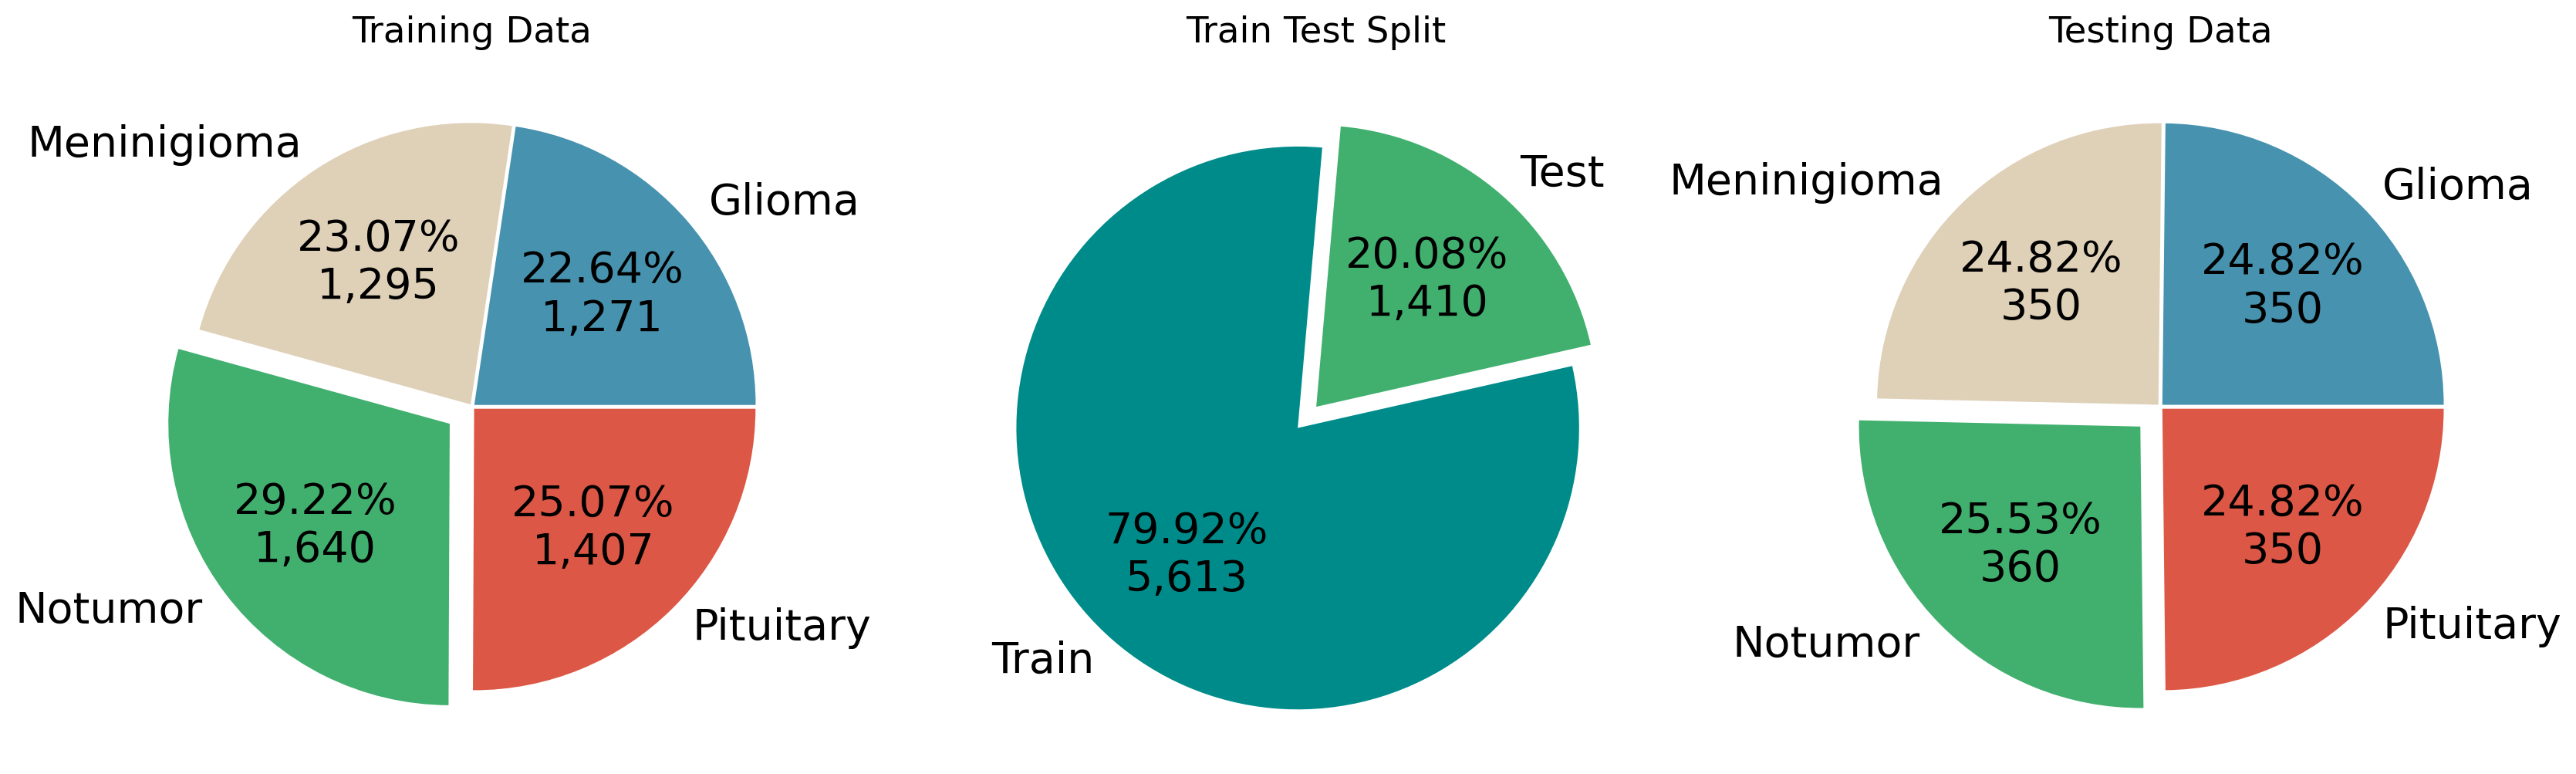

In [ ]:
_, ax = plt.subplots(ncols=3, figsize=(20, 14))

# Plotting training data types
class_counts = [len([x for x in train_index if x == label]) for label in set(train_index)]
ax[0].set_title('Training Data')
ax[0].pie(
    class_counts,
    labels=[label for label in class_names],
    colors=['#4793AF','#DFD0B8', '#41B06E','#DD5746'],
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(class_counts) / 100),
    explode=(0.01, 0.01, 0.1, 0.01),
    textprops={'fontsize': 20}
)

# Plotting distribution of train test split
ax[1].set_title('Train Test Split')
ax[1].pie(
    [len(train_index), len(test_index)],
    labels=['Train','Test'],
    colors=['darkcyan', '#41B06E'],
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum([len(train_index), len(test_index)]) / 100),
    explode=(0.1, 0),
    startangle=85,
    textprops={'fontsize': 20}
)

# Plotting testing data types
class_counts = [len([x for x in test_index if x == label]) for label in set(test_index)]
ax[2].set_title('Testing Data')
ax[2].pie(
    class_counts,
    labels=[label for label in class_names],
    colors=['#4793AF','#DFD0B8', '#41B06E','#DD5746'],
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(class_counts) / 100),
    explode=(0.01, 0.01, 0.1, 0.01),
    textprops={'fontsize': 20}
)

plt.show()

## <div style="font-size: 100%; background-color: cyan; color: black; border-radius: 12px; padding: 10px; margin-bottom: 10px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);">4.1 | Viewing Image Data <b>
    
- Note that the color channels are all the same, grayscale, so we will use only one channel.

In [ ]:
# Function to display a list of images based on the given index
def show_images(paths, label_paths, class_mappings, index_list=range(10), im_size=250, figsize=(12, 8)):

    num_images = len(index_list)
    num_rows = (num_images + 3) // 4
    index_to_class = {v: k for k, v in class_mappings.items()}
    _, ax = plt.subplots(nrows=num_rows, ncols=4, figsize=figsize)
    ax = ax.flatten()

    for i, index in enumerate(index_list):
        if i >= num_images:
            break
        image = load_img(paths[index], target_size=(im_size, im_size), color_mode='grayscale')
        ax[i].imshow(image, cmap='Greys_r')
        class_name = index_to_class[label_paths[index]]
        ax[i].set_title(f'{index}: {class_name}')
        ax[i].axis('off')

    plt.tight_layout()
    plt.show()

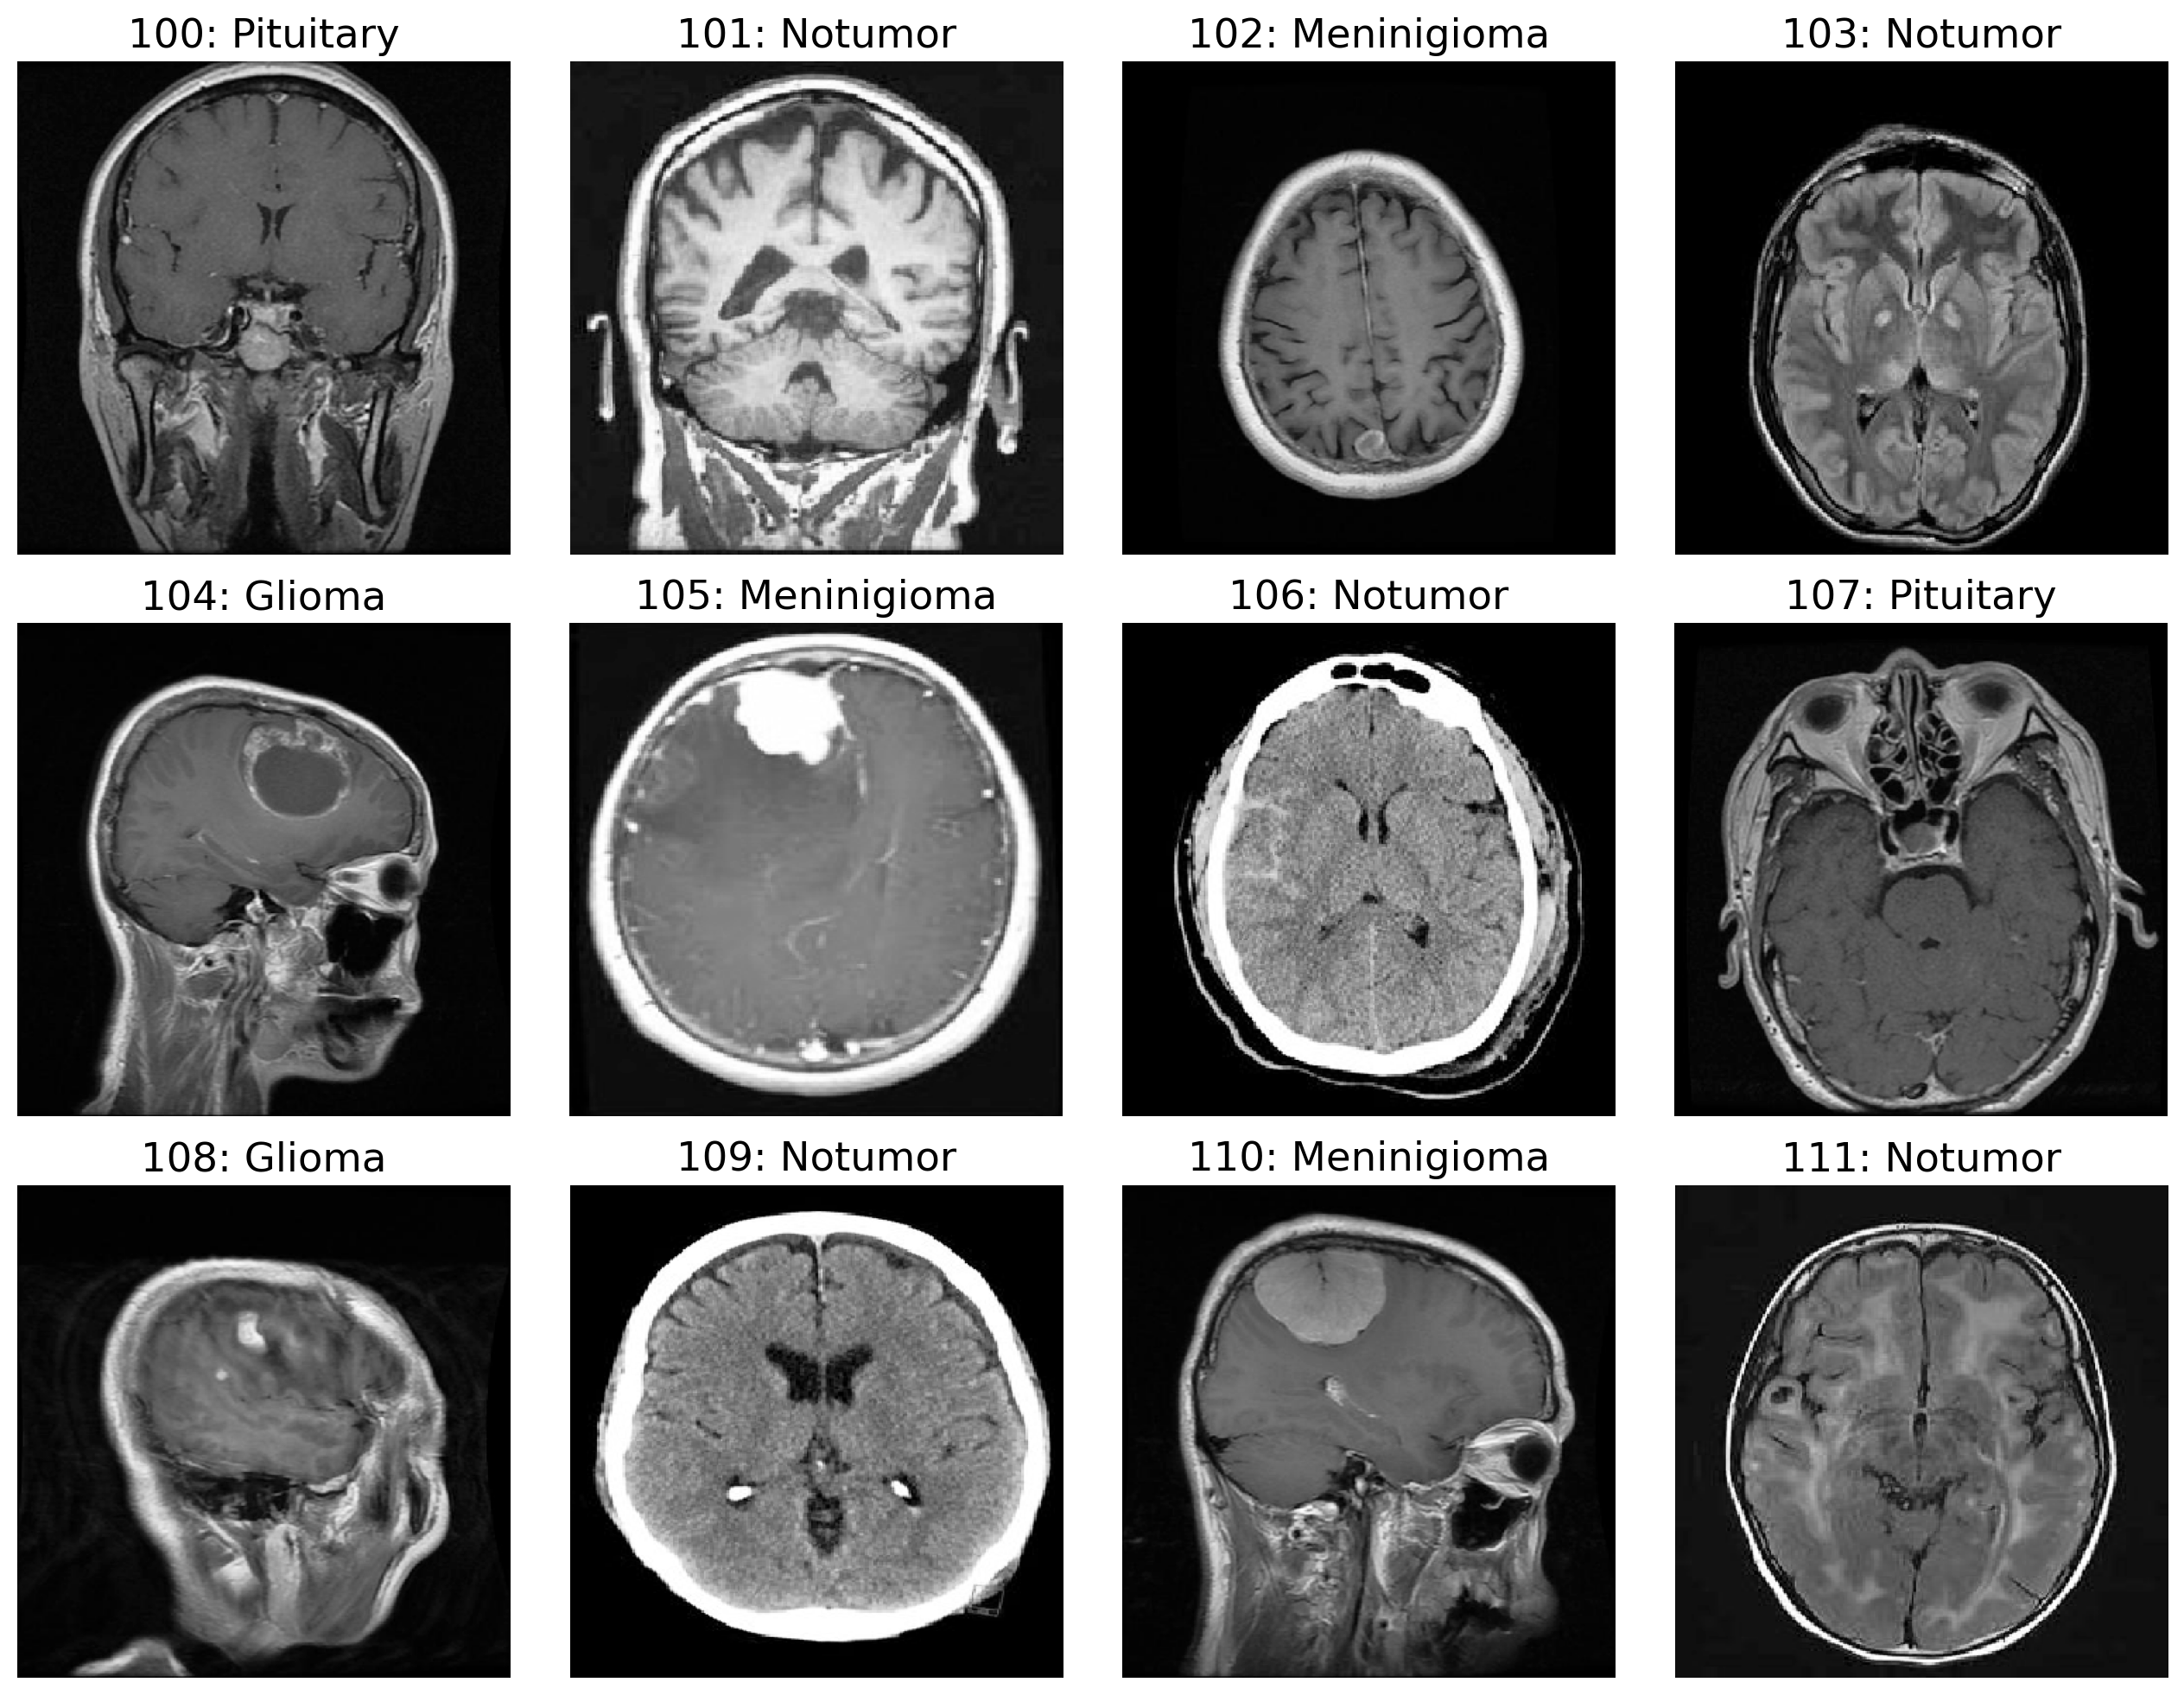

In [ ]:
# Four images from different angles
show_images(train_paths, train_index, class_mappings, im_size=350, figsize=(13,10),
            index_list=range(100, 112))

#**5 | Training Setup**

## <div style="font-size: 100%; background-color: cyan; color: black; border-radius: 12px; padding: 10px; margin-bottom: 10px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);">5.1 | Augmentation Images <b>

In [ ]:
# Dta augmentation sequential model
data_augmentation = Sequential([
    # RandomFlip("horizontal_and_vertical"),
    RandomFlip("horizontal"),
    RandomRotation(0.02, fill_mode='constant'),
    RandomContrast(0.1),
    RandomZoom(height_factor=0.01, width_factor=0.05),
    RandomTranslation(height_factor=0.0015, width_factor=0.0015, fill_mode='constant'),
])


# Training augmentation and nornalization
def preprocess_train(image, label):
    # Apply data augmentation and Normalize
    image = data_augmentation(image) / 255.0
    return image, label

# For test dataset only appying normalization
def preprocess_test(image, label):
    return image / 255.0, label

# Apply transformation to training and testing datasets
train_ds_preprocessed = train_ds.map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds.map(preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)

## <div style="font-size: 100%; background-color: cyan; color: black; border-radius: 12px; padding: 10px; margin-bottom: 10px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1); ">5.2 | Training Setup <b>

In [ ]:
# Classes and Image shape: height, width, grayscale
num_classes = len(class_mappings.keys())
image_shape = (image_dim[0], image_dim[1], 1)

# Training epochs and batch size
epochs = 35
print(f'Number of Classes: {num_classes}')
print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')
print(f'Batch size: {batch_size}')

def encode_labels(image, label):
    return image, tf.one_hot(label, depth=num_classes)

train_ds_preprocessed = train_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)

Number of Classes: 4
Image shape: (168, 168, 1)
Epochs: 35
Batch size: 32


#**6 | Building Model**

## **Attention Mechanism**

In [ ]:
def attention(input_tensor, ratio=16):
    # Create a squeeze-and-excitation block
    filters = input_tensor.shape[-1]  # Using the channel dimension
    se = GlobalAveragePooling2D()(input_tensor)
    se = Reshape((1, 1, filters))(se)
    se = Dense(filters // ratio, activation='relu', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', use_bias=False)(se)
    x = Multiply()([input_tensor, se])
    return x

In [ ]:
from keras.layers import Dropout, BatchNormalization

input_tensor = Input(shape=image_shape)

# Convolutional layers with Dropout and BatchNormalization
x = Conv2D(64, (5, 5), activation="relu")(input_tensor)
x = MaxPooling2D(pool_size=(3, 3))(x)
x = Dropout(0.25)(x)
x = BatchNormalization()(x)
x = Conv2D(64, (5, 5), activation="relu")(x)
x = attention(x)
x = MaxPooling2D(pool_size=(3, 3))(x)
x = Dropout(0.25)(x)
x = BatchNormalization()(x)
x = Conv2D(128, (4, 4), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
x = BatchNormalization()(x)
x = Conv2D(128, (4, 4), activation="relu")(x)
x = attention(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
x = Dense(128, activation="relu")(x)
x = Dense(num_classes, activation="softmax")(x)

# Create and compile the model
model = Model(inputs=input_tensor, outputs=x)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 168, 168, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 164, 164, 64)         1664      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 54, 54, 64)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 dropout (Dropout)           (None, 54, 54, 64)           0         ['max_pooling2d[0][0]']   

In [ ]:
from keras.layers import concatenate
from keras.layers import Dropout, BatchNormalization

input_tensor = Input(shape=image_shape)

# Branch x
x = Conv2D(64, (5, 5), activation="relu")(input_tensor)
x = MaxPooling2D(pool_size=(3, 3))(x)
x = Dropout(0.25)(x)
x = BatchNormalization()(x)
x = Conv2D(64, (5, 5), activation="relu")(x)
x = attention(x)
x = MaxPooling2D(pool_size=(3, 3))(x)
x = Dropout(0.25)(x)
x = BatchNormalization()(x)

# Branch y
y = Conv2D(64, (5, 5), activation="relu")(input_tensor)
y = MaxPooling2D(pool_size=(3, 3))(y)
y = Dropout(0.25)(y)
y = BatchNormalization()(y)
y = Conv2D(64, (5, 5), activation="relu")(y)
y = MaxPooling2D(pool_size=(3, 3))(y)
y = Dropout(0.25)(y)
y = BatchNormalization()(y)
y = Conv2D(128, (4, 4), activation="relu")(y)
y = MaxPooling2D(pool_size=(2, 2))(y)
y = Dropout(0.25)(y)
y = BatchNormalization()(y)
y = Conv2D(128, (4, 4), activation="relu")(y)
y = attention(y)
y = MaxPooling2D(pool_size=(2, 2))(y)
y = Dropout(0.25)(y)
y = BatchNormalization()(y)

x = Flatten()(x)
y = Flatten()(y)
# Concatenate branches x and y
concatenated = concatenate([x, y])

# Flatten layer
a = Flatten()(concatenated)
a = Dense(256, activation="relu")(a)
a = Dense(128, activation="relu")(a)
a = Dense(num_classes, activation="softmax")(a)

# Create and compile the model
model = Model(inputs=input_tensor, outputs=a)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 168, 168, 1)]        0         []                            
                                                                                                  
 conv2d_40 (Conv2D)          (None, 164, 164, 64)         1664      ['input_9[0][0]']             
                                                                                                  
 max_pooling2d_28 (MaxPooli  (None, 54, 54, 64)           0         ['conv2d_40[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 dropout_40 (Dropout)        (None, 54, 54, 64)           0         ['max_pooling2d_28[0][0]']

In [ ]:
from keras.layers import concatenate
from keras.layers import Dropout, BatchNormalization

input_tensor = Input(shape=image_shape)

# Branch x includes attention mechanism
x = Conv2D(64, (5, 5), activation="relu")(input_tensor)
x = MaxPooling2D(pool_size=(3, 3))(x)
x = Conv2D(64, (5, 5), activation="relu")(x)
x = MaxPooling2D(pool_size=(3, 3))(x)
x = BatchNormalization()(x)
x = Conv2D(128, (4, 4), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(128, (4, 4), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

# Branch y includes attention mechanism
y = Conv2D(64, (5, 5), activation="relu")(input_tensor)
y = MaxPooling2D(pool_size=(3, 3))(y)
y = Conv2D(64, (5, 5), activation="relu")(y)
y = MaxPooling2D(pool_size=(3, 3))(y)
y = BatchNormalization()(y)
y = Conv2D(128, (4, 4), activation="relu")(y)
y = MaxPooling2D(pool_size=(2, 2))(y)
y = Conv2D(128, (4, 4), activation="relu")(y)
y = attention(y)  # Attention mechanism
y = MaxPooling2D(pool_size=(2, 2))(y)
y = Dropout(0.25)(y)


# Concatenate branches and add dense layers
x = Flatten()(x)
y = Flatten()(y)
concatenated = concatenate([x, y])
a = Flatten()(concatenated)
a = Dense(256, activation="relu")(a)
a = Dense(128, activation="relu")(a)
a = Dense(num_classes, activation="softmax")(a)
# Create and compile the model
model = Model(inputs=input_tensor, outputs=a)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 168, 168, 1)]        0         []                            
                                                                                                  
 conv2d_57 (Conv2D)          (None, 164, 164, 64)         1664      ['input_9[0][0]']             
                                                                                                  
 max_pooling2d_51 (MaxPooli  (None, 54, 54, 64)           0         ['conv2d_57[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 conv2d_58 (Conv2D)          (None, 50, 50, 64)           102464    ['max_pooling2d_51[0][0]

In [ ]:
from keras.layers import concatenate
from keras.layers import Dropout, BatchNormalization

input_tensor = Input(shape=image_shape)

# Branch y includes attention mechanism
y = Conv2D(64, (5, 5), activation="relu")(input_tensor)
y = MaxPooling2D(pool_size=(3, 3))(y)
y = Conv2D(64, (5, 5), activation="relu")(y)
y = MaxPooling2D(pool_size=(3, 3))(y)
y = BatchNormalization()(y)
y = Conv2D(128, (4, 4), activation="relu")(y)
y = MaxPooling2D(pool_size=(2, 2))(y)
y = Conv2D(128, (4, 4), activation="relu")(y)
y = attention(y)  # Attention mechanism
y = MaxPooling2D(pool_size=(2, 2))(y)
y = Dropout(0.25)(y)
y = Flatten()(y)
x = Dense(256, activation="relu")(y)
x = Dense(128, activation="relu")(x)
x = Dense(num_classes, activation="softmax")(x)

# Create and compile the model
model = Model(inputs=input_tensor, outputs=x)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 168, 168, 1)]        0         []                            
                                                                                                  
 conv2d_41 (Conv2D)          (None, 164, 164, 64)         1664      ['input_7[0][0]']             
                                                                                                  
 max_pooling2d_36 (MaxPooli  (None, 54, 54, 64)           0         ['conv2d_41[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 conv2d_42 (Conv2D)          (None, 50, 50, 64)           102464    ['max_pooling2d_36[0][0]

## **CNN Training**

In [ ]:
# Custom callback for reducing learning rate at accuracy values
class ReduceLROnMultipleAccuracies(tf.keras.callbacks.Callback):
    def __init__(self, thresholds, factor, monitor='val_accuracy', verbose=1):
        super(ReduceLROnMultipleAccuracies, self).__init__()
        self.thresholds = thresholds  # List of accuracy thresholds
        self.factor = factor  # Factor to reduce the learning rate
        self.monitor = monitor
        self.verbose = verbose
        self.thresholds_reached = [False] * len(thresholds)  # Track each threshold

    def on_epoch_end(self, epoch, logs=None):
        current_accuracy = logs.get(self.monitor)
        for i, threshold in enumerate(self.thresholds):
            if current_accuracy >= threshold and not self.thresholds_reached[i]:
                optimizer = self.model.optimizer
                old_lr = optimizer.learning_rate.numpy()
                new_lr = old_lr * self.factor
                optimizer.learning_rate.assign(new_lr)
                self.thresholds_reached[i] = True  # Mark this threshold as reached
                if self.verbose > 0:
                    print(f"\nEpoch {epoch+1}: {self.monitor} reached {threshold}. Reducing learning rate from {old_lr} to {new_lr}.")

# Try a custom callback
thresholds = [0.96, 0.99, 0.9935]
lr_callback = ReduceLROnMultipleAccuracies(thresholds=thresholds, factor=0.75, monitor='val_accuracy', verbose=False)

###**Training Data For Attention Mechanism**

In [ ]:
# Callbacks for improved covergence of gradient and best test accuracy
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, min_lr=1e-4, patience=4, verbose=False)
model_mc = ModelCheckpoint('model.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=False)

# Training the model
history = model.fit(
    train_ds_preprocessed,
    epochs=epochs,
    validation_data=test_ds_preprocessed,
    callbacks=[model_rlr, model_mc],
    verbose=True
)

Epoch 1/35
176/176 [==============================] - 937s 5s/step - loss: 0.6898 - accuracy: 0.7597 - val_loss: 5.5034 - val_accuracy: 0.2482 - lr: 0.0010
Epoch 2/35
176/176 [==============================] - 45s 256ms/step - loss: 0.3982 - accuracy: 0.8514 - val_loss: 3.4974 - val_accuracy: 0.4220 - lr: 0.0010
Epoch 3/35
176/176 [==============================] - 40s 227ms/step - loss: 0.2995 - accuracy: 0.8933 - val_loss: 0.8582 - val_accuracy: 0.6986 - lr: 0.0010
Epoch 4/35
176/176 [==============================] - 41s 229ms/step - loss: 0.2209 - accuracy: 0.9180 - val_loss: 0.4185 - val_accuracy: 0.8340 - lr: 0.0010
Epoch 5/35
176/176 [==============================] - 41s 232ms/step - loss: 0.1611 - accuracy: 0.9405 - val_loss: 0.2751 - val_accuracy: 0.8915 - lr: 0.0010
Epoch 6/35
176/176 [==============================] - 46s 261ms/step - loss: 0.1375 - accuracy: 0.9485 - val_loss: 0.6111 - val_accuracy: 0.8376 - lr: 0.0010
Epoch 7/35
176/176 [==============================] - 

## <div style="font-size: 100%; background-color: cyan; color: black; border-radius: 12px; padding: 10px; margin-bottom: 10px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);">6.2 | Model Evaluation <b>

In [ ]:
# Loading saved model
model = load_model('model.keras')

# Evaluate model and test data accuracy
test_loss, test_acc = model.evaluate(test_ds_preprocessed)
print(f"Test accuracy: {test_acc*100.00:0.4f}%")

45/45 [==============================] - 6s 128ms/step - loss: 0.1041 - accuracy: 0.9837
Test accuracy: 98.3688%


In [ ]:
def plot_confusion_matrix(true_labels, predicted_labels, class_mappings, metrics=False, cmap='Blues'):
    # Compute  confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

    # Mapping of indices to class names in class_mappings
    plt.xticks(ticks=np.arange(num_classes) + 0.5, labels=class_mappings.keys(), ha='center')
    plt.yticks(ticks=np.arange(num_classes) + 0.5, labels=class_mappings.keys(), va='center')
    plt.show()

    if metrics:
        # Precision, Recall, and F1-Score for each class & Overall accuracy
        precision = np.diag(cm) / np.sum(cm, axis=0)
        recall = np.diag(cm) / np.sum(cm, axis=1)
        f1_scores = 2 * precision * recall / (precision + recall)
        accuracy = np.sum(np.diag(cm)) / np.sum(cm)

        print("Class-wise metrics:")
        for i in range(len(class_mappings)):
            class_name = list(class_mappings.keys())[i]
            print(f"\033[94mClass: {class_name}\033[0m")
            print(f"Precision: {precision[i]:.4f}")
            print(f"Recall: {recall[i]:.4f}")
            print(f"F1-Score: {f1_scores[i]:.4f}\n")

        print(f"\033[92mOverall Accuracy: {accuracy:.4f}\033[0m") true_labels

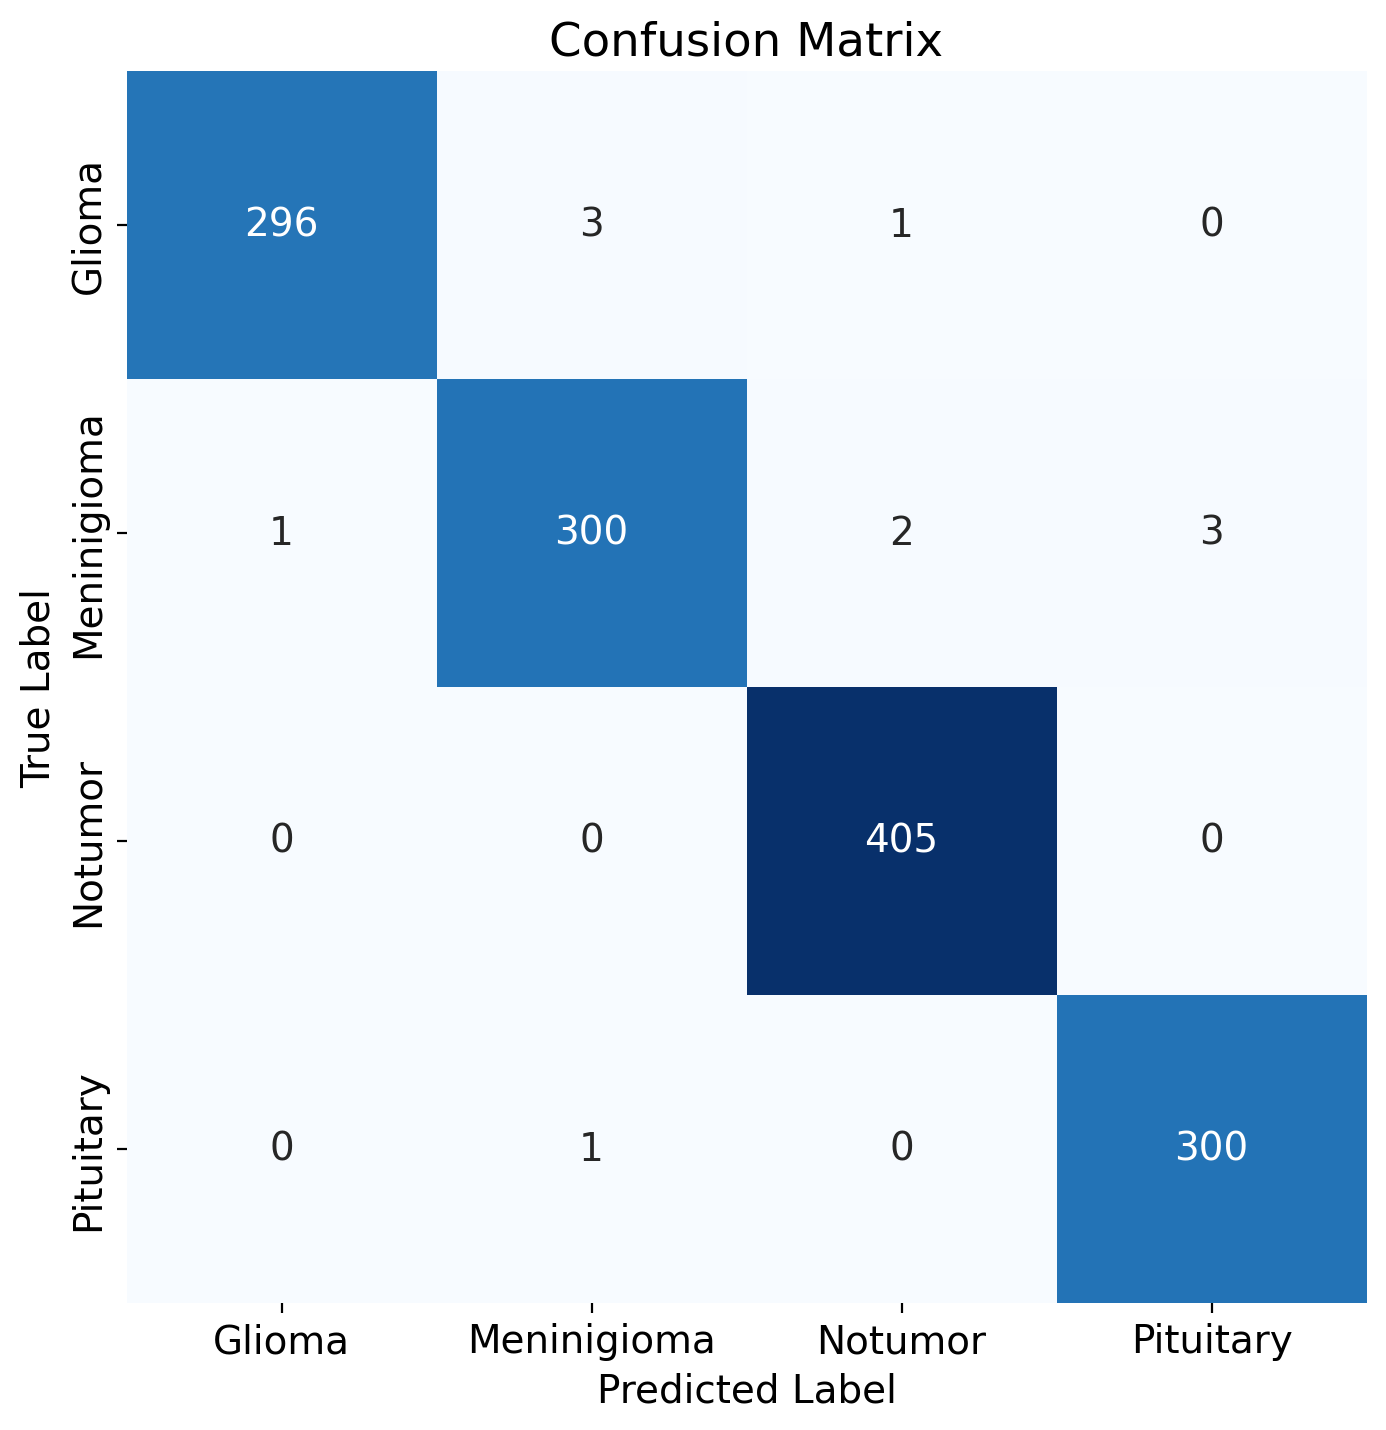

Class-wise metrics:
Class: Glioma
Precision: 0.9966
Recall: 0.9867
F1-Score: 0.9916

Class: Meninigioma
Precision: 0.9868
Recall: 0.9804
F1-Score: 0.9836

Class: Notumor
Precision: 0.9926
Recall: 1.0000
F1-Score: 0.9963

Class: Pituitary
Precision: 0.9901
Recall: 0.9967
F1-Score: 0.9934

Overall Accuracy: 0.9916


In [ ]:
# Confusion matrix and netrics from predictions
plot_confusion_matrix(true_labels,
                      predicted_labels,
                      class_mappings,
                      metrics=True)

In [ ]:
def plot_sample_predictions(model, dataset, index_to_class, num_samples=9, figsize=(13, 12)):
    plt.figure(figsize=figsize)
    num_rows = num_cols = int(np.sqrt(num_samples))

    iterator = iter(dataset.unbatch())

    for i in range(1, num_samples + 1):
        image, true_label = next(iterator)
        image_batch = tf.expand_dims(image, 0)
        predictions = model.predict(image_batch, verbose=False)
        predicted_label = np.argmax(predictions, axis=1)[0]

        true_class_index = np.argmax(true_label.numpy())
        true_class = index_to_class[true_class_index]
        predicted_class = index_to_class[predicted_label]

        # Determine title color based on prediction accuracy
        title_color = 'green' if true_class_index == predicted_label else 'red'

        plt.subplot(num_rows, num_cols, i)
        plt.imshow(image.numpy().squeeze(), cmap='gray')
        plt.title(f"True: {true_class}\nPred: {predicted_class}", color=title_color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

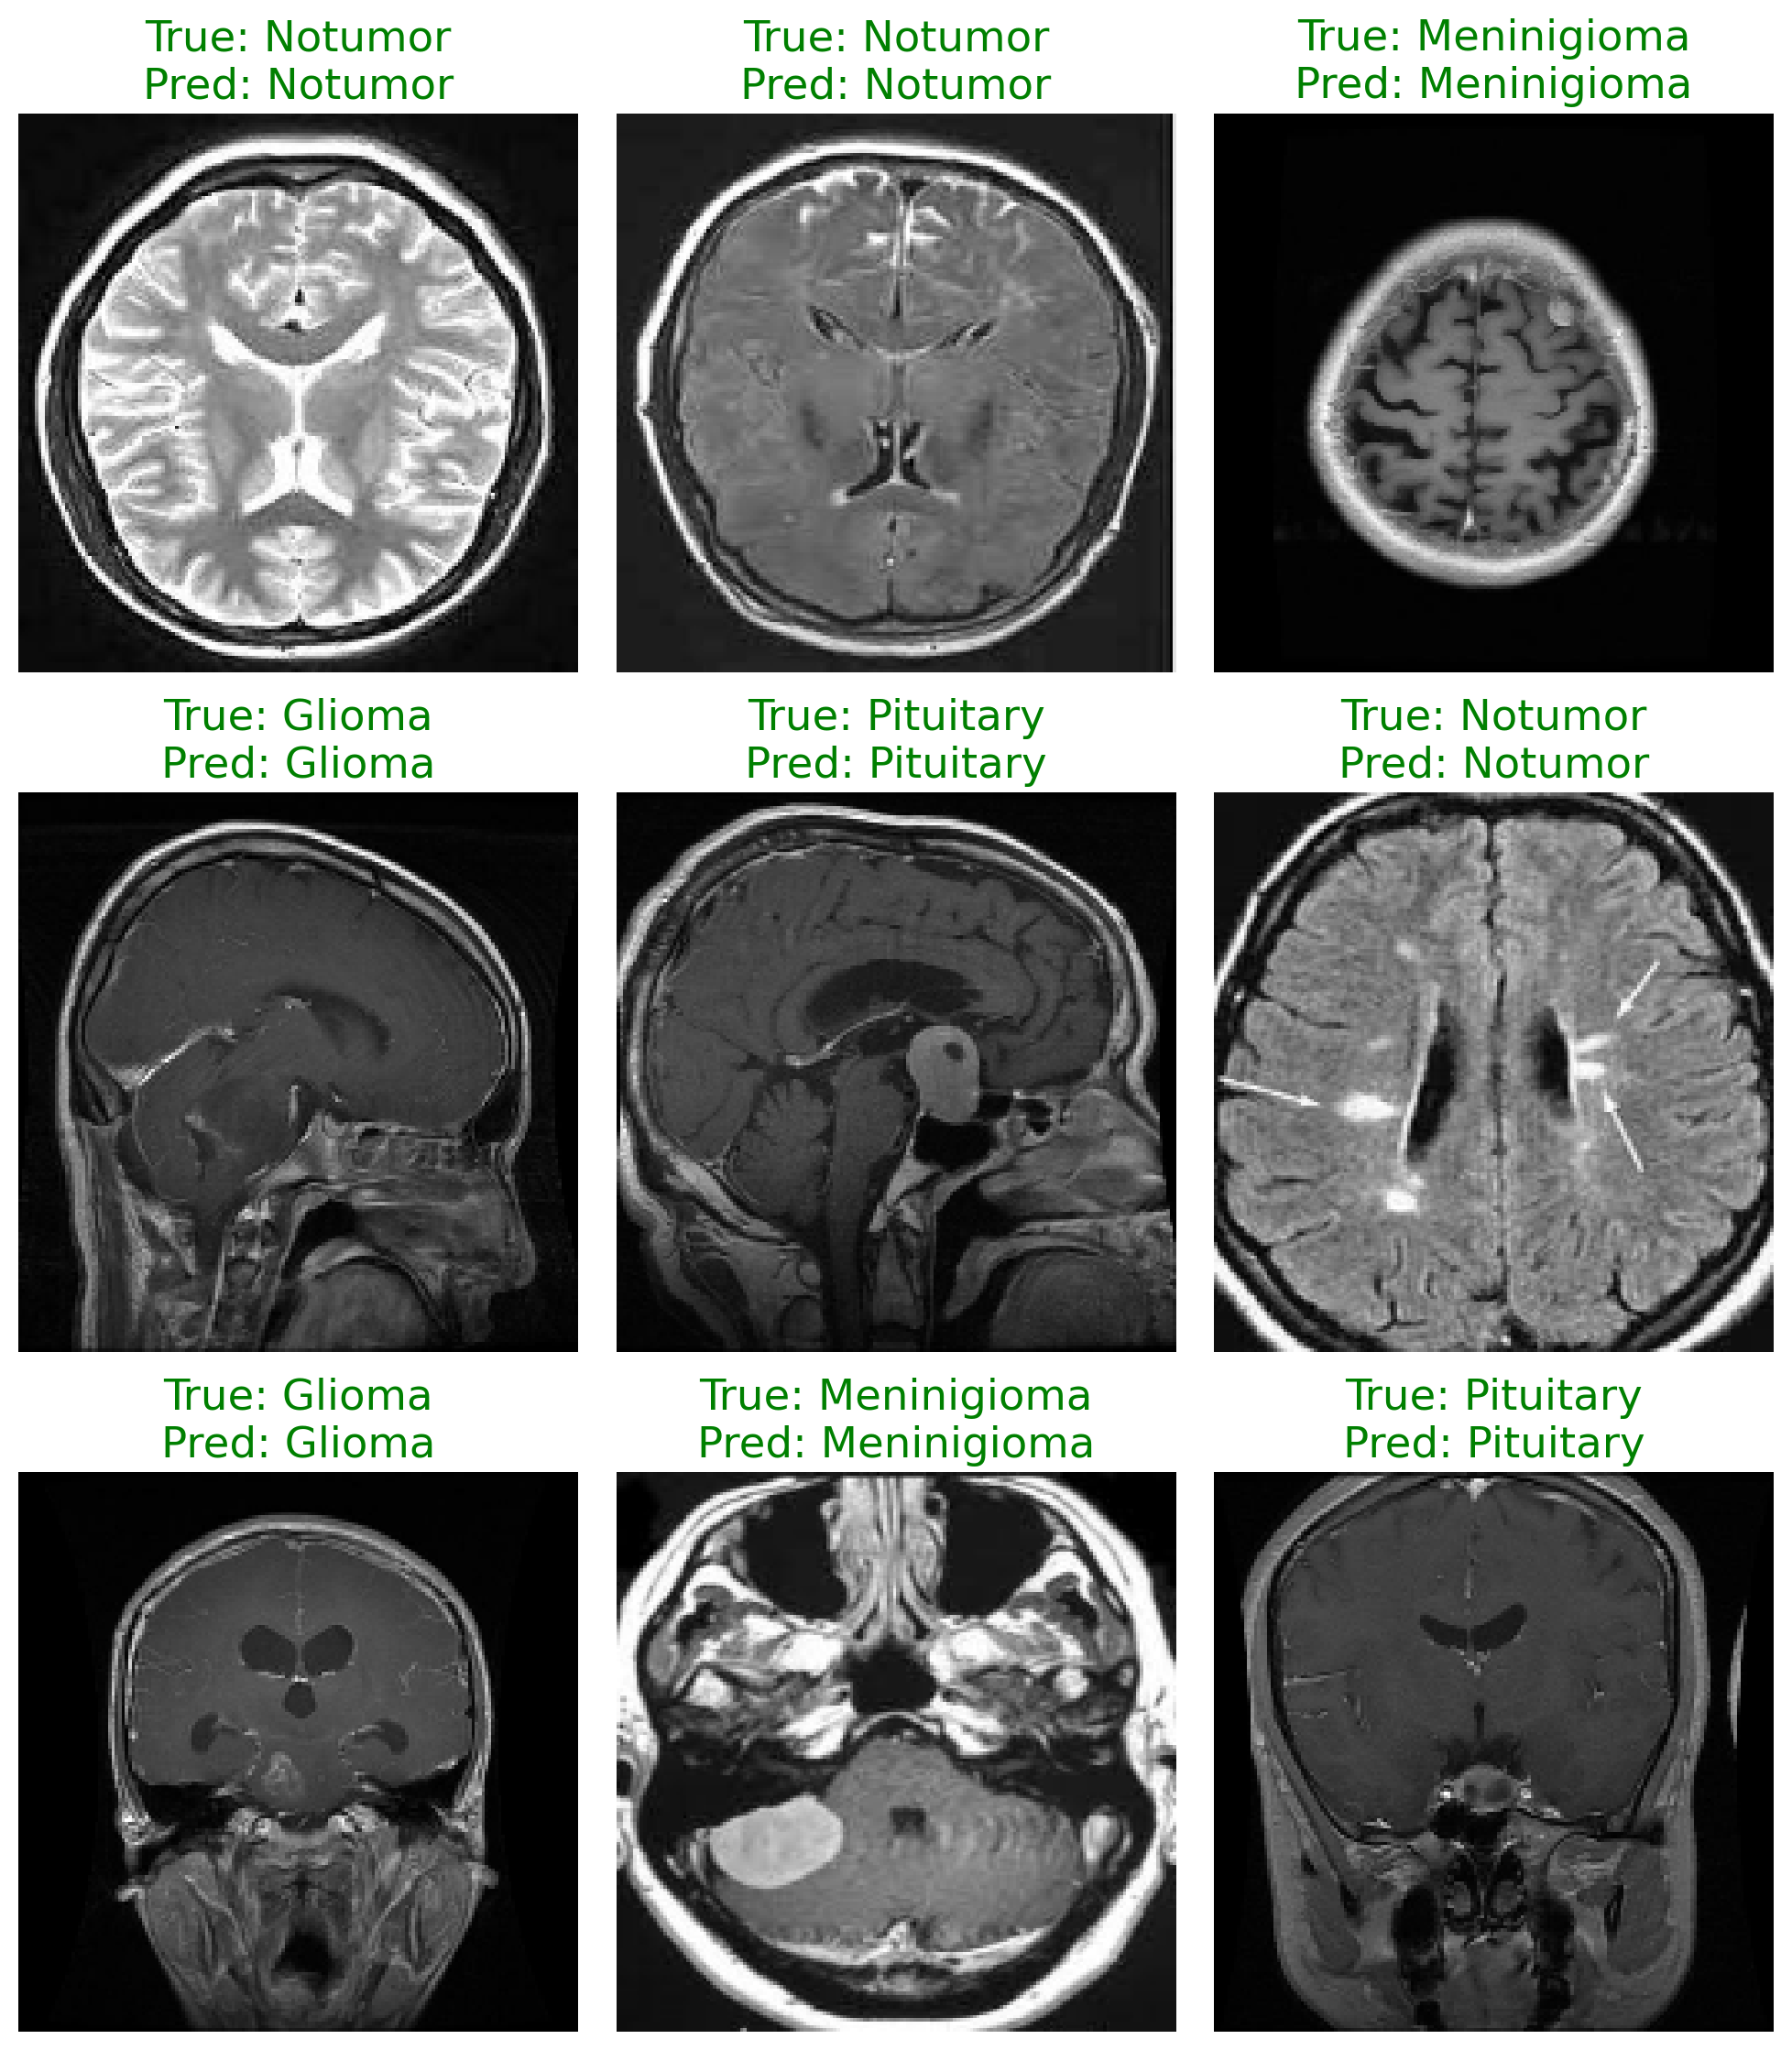

In [ ]:
# Plottinng samples with predictions
plot_sample_predictions(model=model,
                        dataset=test_ds_preprocessed,
                        index_to_class=inv_class_mappings,
                        num_samples=9,
                        figsize=(10, 11.5))

## <div style="font-size: 100%; background-color: cyan; color: black; border-radius: 12px; padding: 10px; margin-bottom: 10px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);">6.3 | Misclassified Tumors <b>

In [ ]:
def plot_misclassified_samples(model, dataset, index_to_class, figsize=(10, 10)):
    misclassified_images = []
    misclassified_labels = []
    misclassified_predictions = []

    # Iterate over dataset to collect misclassified images
    for image, true_label in dataset.unbatch():
        image_batch = tf.expand_dims(image, 0)
        predictions = model.predict(image_batch, verbose=False)
        predicted_label = np.argmax(predictions, axis=1)[0]
        true_class_index = np.argmax(true_label.numpy())

        if true_class_index != predicted_label:
            misclassified_images.append(image.numpy().squeeze())
            misclassified_labels.append(index_to_class[true_class_index])
            misclassified_predictions.append(index_to_class[predicted_label])

    # Determine number of rows and columns for subplot
    num_misclassified = len(misclassified_images)
    cols = int(np.sqrt(num_misclassified)) + 1
    rows = num_misclassified // cols + (num_misclassified % cols > 0)

    # Plotting misclassified images
    miss_classified_zip = zip(misclassified_images, misclassified_labels, misclassified_predictions)
    plt.figure(figsize=figsize)
    for i, (image, true_label, predicted_label) in enumerate(miss_classified_zip):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"True: {true_label}\nPred: {predicted_label}", color='red')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

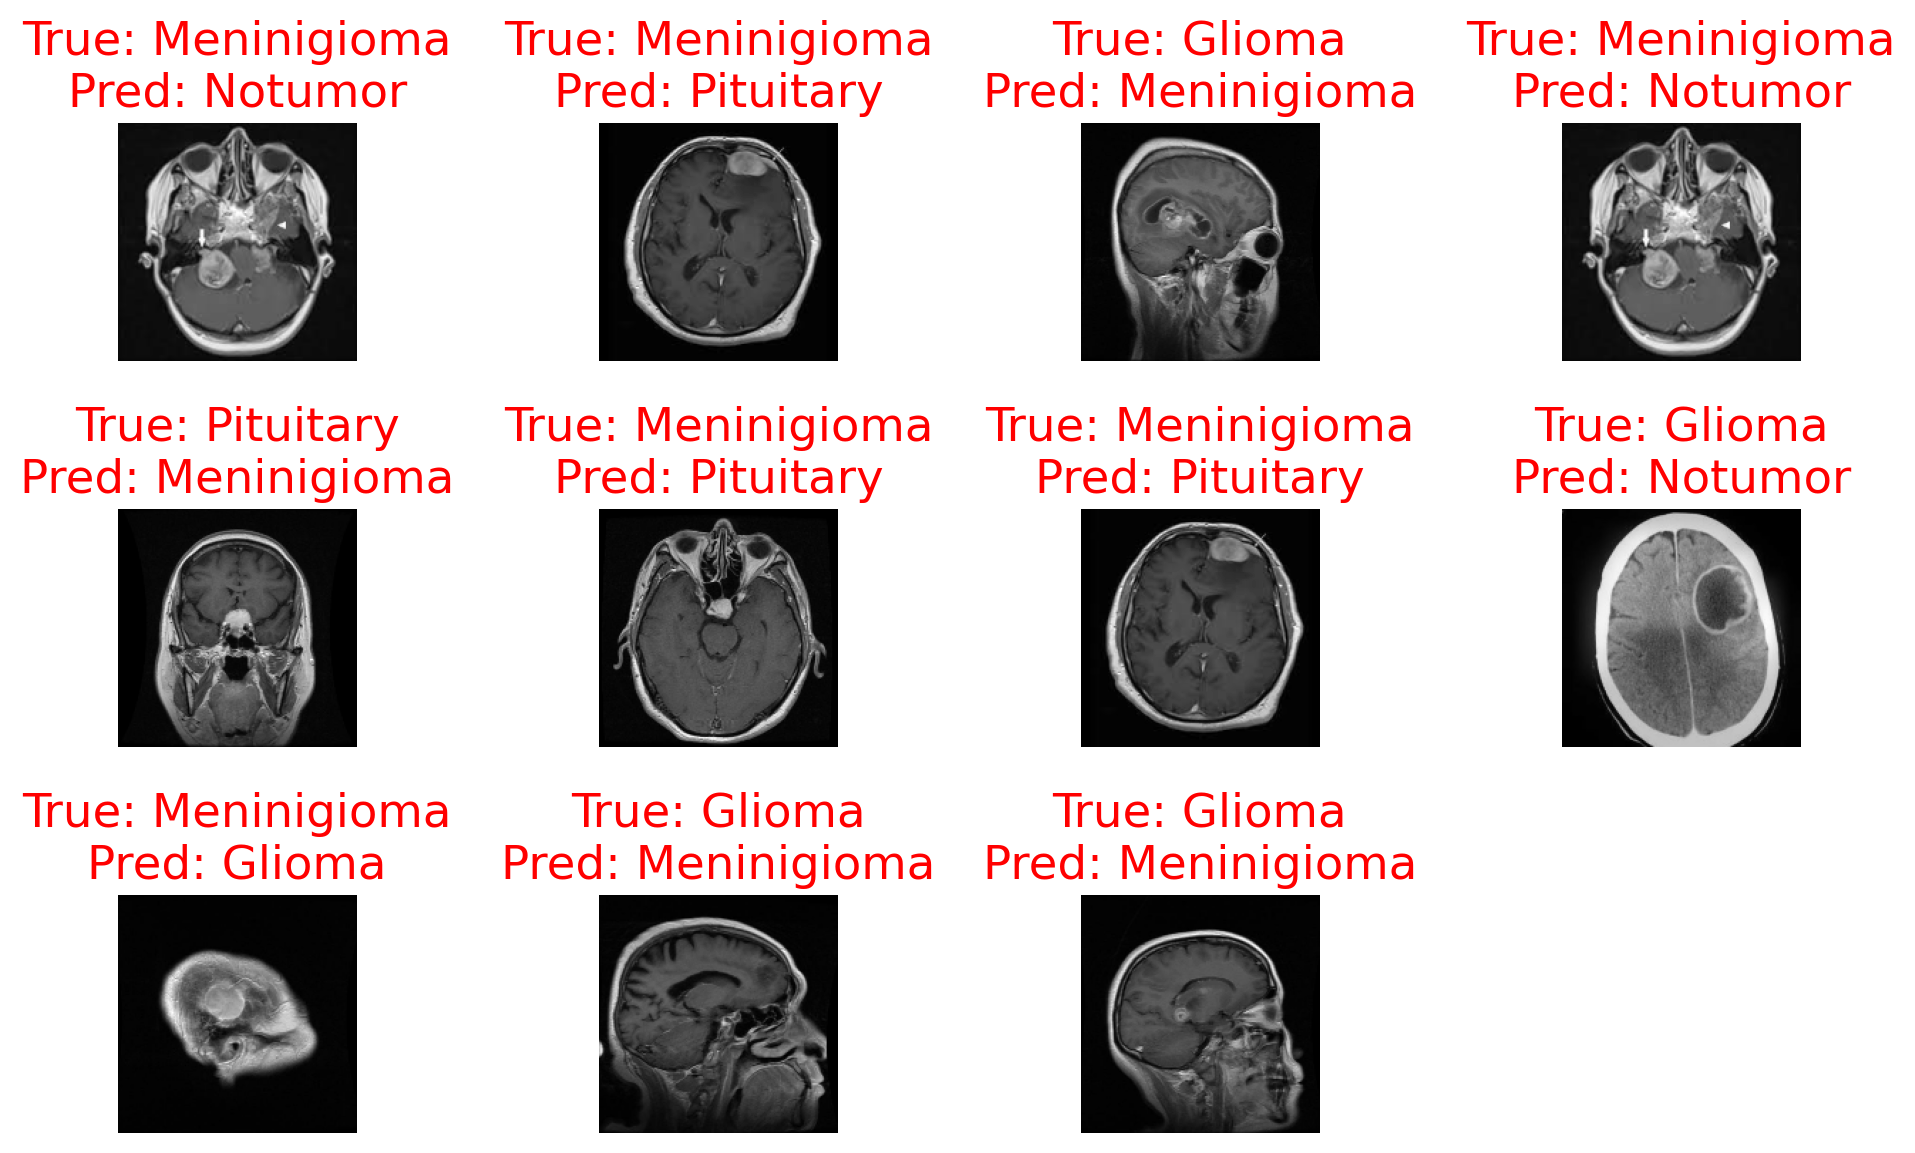

In [ ]:
# Plotting misclassified images
plot_misclassified_samples(model=model,
                           dataset=test_ds_preprocessed,
                           index_to_class=inv_class_mappings,
                           figsize=(10, 6))

#**7 | Test New Data**

In [ ]:
# Function to load and preprocess an image
def load_and_preprocess_image(image_path, image_shape=(168, 168)):
    img = image.load_img(image_path, target_size=image_shape, color_mode='grayscale')
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Add the batch dimension
    return img_array

# Function to display a row of images with predictions
def display_images_and_predictions(image_paths, predictions, true_labels, figsize=(20, 5)):
    plt.figure(figsize=figsize)
    for i, (image_path, prediction, true_label) in enumerate(zip(image_paths, predictions, true_labels)):
        ax = plt.subplot(1, len(image_paths), i + 1)
        img_array = load_and_preprocess_image(image_path)
        img_array = np.squeeze(img_array)
        plt.imshow(img_array, cmap='gray')
        title_color = 'green' if prediction == true_label else 'red'
        plt.title(f'True Label: {true_label}\nPred: {prediction}', color=title_color)
        plt.axis('off')
    plt.show()

1/1 [==============================] - 0s 56ms/step
Class Mappings: {'Glioma': 0, 'Meninigioma': 1, 'Notumor': 2, 'Pituitary': 3}

Normal Image Prediction: [0. 0. 1. 0.]
Glioma Image Prediction: [1. 0. 0. 0.]
Meningioma Image Prediction: [0.    0.996 0.004 0.   ]
Pituitary Image Prediction: [0. 0. 0. 1.]


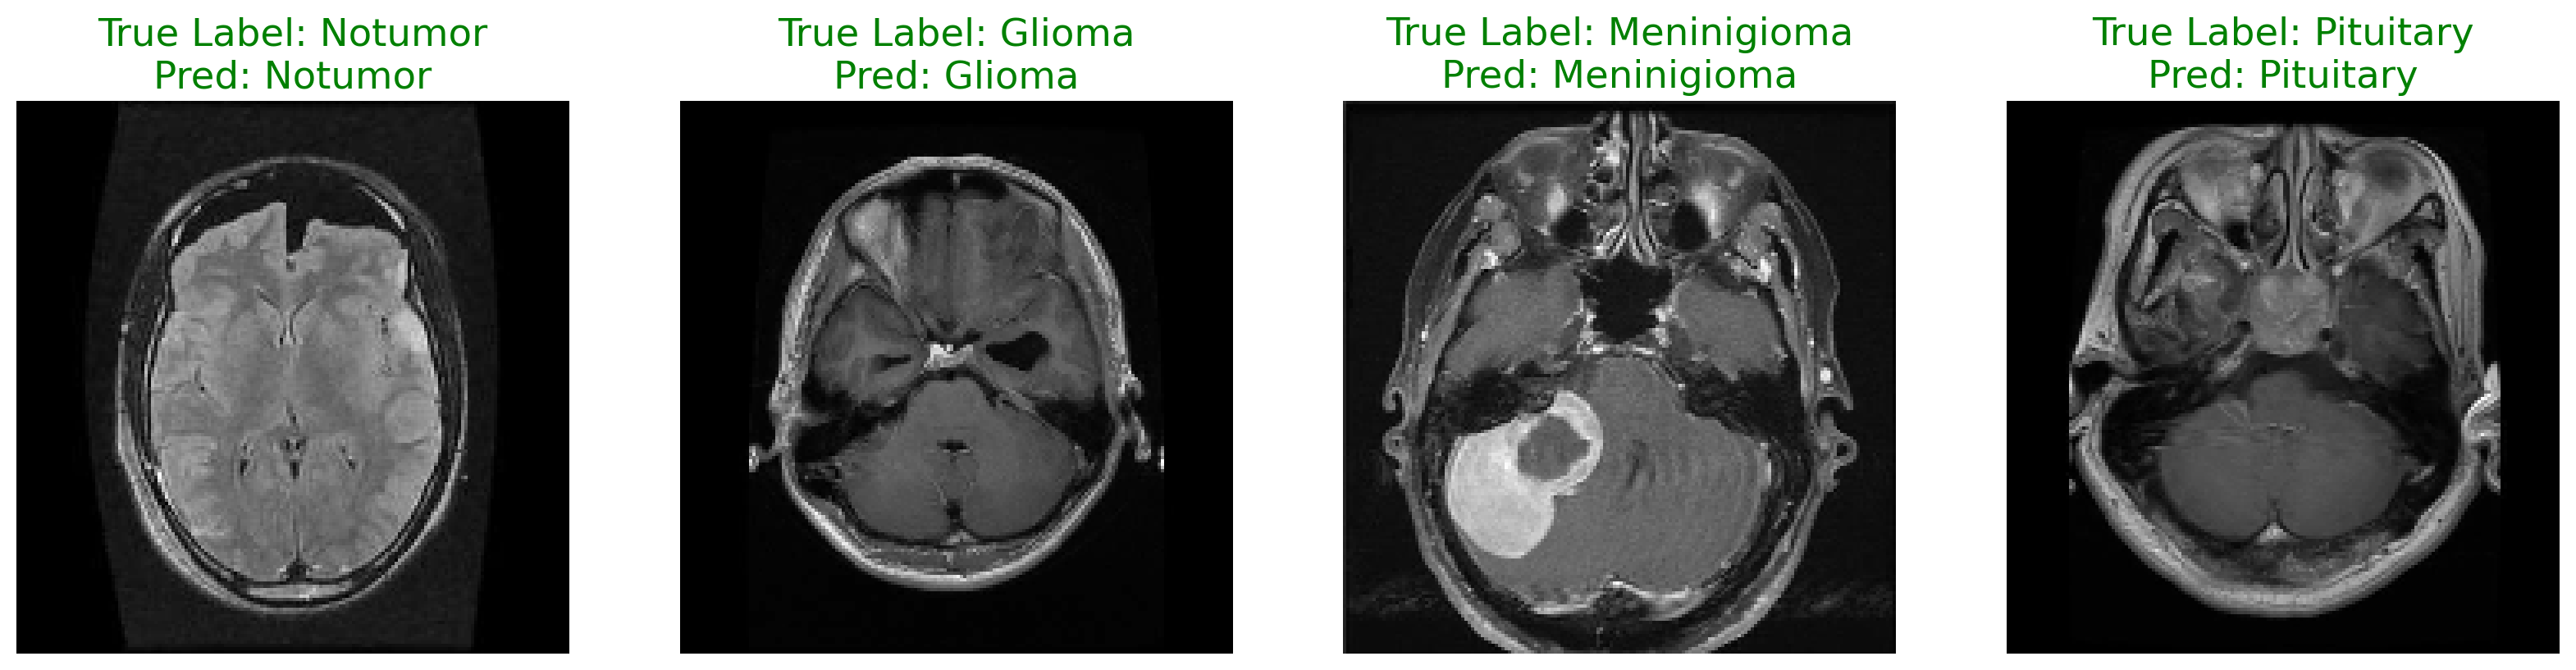

In [ ]:
# Load and preprocess the images
normal_image_path = '/content/drive/MyDrive/Expreimentation/Final Processed Dataset/Testing/notumor/Te_no_0009.jpg'
glioma_image_path = '/content/drive/MyDrive/Expreimentation/Final Processed Dataset/Testing/glioma/Te_gl_0005.jpg'
meningioma_image_path = '/content/drive/MyDrive/Expreimentation/Final Processed Dataset/Testing/meningioma/Te_me_0008.jpg'
pituitary_tumor_path = '/content/drive/MyDrive/Expreimentation/Final Processed Dataset/Testing/pituitary/Te_pi_0025.jpg'

# Image paths
image_paths = [
    normal_image_path,
    glioma_image_path,
    meningioma_image_path,
    pituitary_tumor_path
]

# True labels for images
true_labels = ['Notumor', 'Glioma', 'Meninigioma', 'Pituitary']

# Load and preprocess images, then make predictions
images = [load_and_preprocess_image(path) for path in image_paths]
predictions = [model.predict(image) for image in images]

# Determine the predicted labels
predicted_labels = [inv_class_mappings[np.argmax(one_hot)] for one_hot in predictions]

# Output the predictions
print(f'Class Mappings: {class_mappings}')
print("\nNormal Image Prediction:", np.round(predictions[0], 3)[0])
print("Glioma Image Prediction:", np.round(predictions[1], 3)[0])
print("Meningioma Image Prediction:", np.round(predictions[2], 3)[0])
print("Pituitary Image Prediction:", np.round(predictions[3], 3)[0])

# Display images with predictions
display_images_and_predictions(image_paths, predicted_labels, true_labels)